In [ ]:
import os, random
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [ ]:
def check_prox(a, b, threshhold):
    #get distance from a to b
    delta_x = np.abs(a[0] - b[0])
    delta_y = np.abs(a[1] - b[1])
    dist = np.sqrt(np.square(delta_x) + np.square(delta_y))

    if(dist <= threshhold):
        return 1
    else:
        return 0

In [ ]:
class PathsDataset(torch.utils.data.Dataset):
    # init the dataset, shape = L x W
    def __init__(self, gen_dir, transform=None, shape = (100,100), device='cpu', stop_after=500):
        self.device = device
        self.maps_and_paths = []

        num_maps = 0
        for directory in tqdm(os.listdir(gen_dir)):
            num_maps += 1
            dir_path = os.path.join(gen_dir, directory)
            sequence = []

            # open map file:
            with open(f"{dir_path}/{directory}.txt", 'r') as f:
                self.flat_map = np.loadtxt(f)
                self.map = np.asarray(self.flat_map, dtype=np.float32).reshape(shape[0],shape[1])

            # add map to sequence array:
            sequence.append(torch.tensor(self.map))

            path_dir = f"{dir_path}/paths/"
            num_paths = 0
            for filename in os.listdir(path_dir):
                num_paths += 1
                with open(os.path.join(path_dir, filename), 'r') as f: # open in readonly mode
                    path_points_list = [] # a list to hold each point in a path
                    self.flat_path = np.loadtxt(f) # load in the flat path from file
                    self.path = np.asarray(self.flat_path, dtype=np.float32).reshape(len(self.flat_path)//2,2) #unflatten the path from the file
                    for point in self.path:
                        x = point[0]
                        y = point[1]
                        this_point = [x, y]
                        path_points_list.append(this_point)
                # sequence = []
                # sequence.append(torch.tensor(self.map))
                sequence.append(torch.tensor(path_points_list, dtype=torch.float)[:, :])
                
            self.maps_and_paths.append(sequence)

            if num_maps == stop_after:
                break
        
        self.transform = transform
        print("Done!")

    def convert_path(self, map_dim, path):
        path_mat = np.zeros(map_dim, dtype=float)

        # Make the path continuous
        for i in range(path.shape[0] - 1):
            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            if (x1 < x2):
                x_dir = 1
            else:
                x_dir = -1

            if (y1 < y2):
                y_dir = 1
            else:
                y_dir = -1

            # Determine y from x
            if x2-x1 != 0:
                m = (y2-y1)/(x2-x1)
                while x != x2:
                    y = round(m*(x-x1) + y1)
                    path_mat[y,x] = 1
                    x += x_dir
            else:
                while x != x2:
                    path_mat[y1,x] = 1
                    x += x_dir


            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            # Determine x from y
            if y2-y1 != 0:
                m = (x2-x1)/(y2-y1)
                while y != y2:
                    x = round(m*(y-y1) + x1)
                    path_mat[y,x] = 1
                    y += y_dir
            else:
                while y != y2:
                    path_mat[y,x1] = 1
                    y += y_dir

        return path

    def __len__(self):
        return len(self.maps_and_paths)

    def __getitem__(self, idx):
        x = self.maps_and_paths[idx]
        if self.transform:
            x = self.transform(x)
        
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# dataset name
MAP_NAME = '8x12_map_cropped'
DATASET = 'train'
MAP_SHAPE = (64,64)
# loading info
ENCODER_PATH = f"checkpoints/encoder/"
DECODER_PATH = f"checkpoints/decoder/"
LOAD_EPOCH = 499
# training parameters
BATCH_SIZE = 1
train_dataset = PathsDataset(gen_dir = f"./env/many_maps_1/{DATASET}/", shape = MAP_SHAPE, transform=None, device=device, stop_after=6000)
dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

#Dropout (yes=1 or no=0)
DROPOUT = 1
DROPOUT_P = 0.2 # what % of nodes to drop out (usually 0.2 to 0.5)

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 16, 5, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 5, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 5, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),     
            nn.Conv2d(64, 128, 7, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),  
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        return x

In [ ]:
# class Decoder(nn.Module):
    
#     def __init__(self):
#         super().__init__()

#         self.unflatten = nn.Unflatten(dim=1, 
#         unflattened_size=(128, 1, 1))

#         self.decoder_conv = nn.Sequential(
#             nn.ConvTranspose2d(128, 64, 7, 
#             stride=2, padding=0, output_padding=0),
#             nn.BatchNorm2d(64),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(64, 32, 5,
#             stride=2, padding=1, output_padding=0),
#             nn.BatchNorm2d(32),
#             nn.ConvTranspose2d(32, 16, 5, 
#             stride=2, padding=1, output_padding=0),
#             nn.BatchNorm2d(16),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(16, 1, 5, 
#             stride=2, padding=1, output_padding=1)
#         )
        
#     def forward(self, x):
#         x = self.unflatten(x)
#         x = self.decoder_conv(x)
#         x = torch.sigmoid(x)
#         return x

In [ ]:
# create a new encoder
encoder = Encoder()
# decoder = Decoder()

In [ ]:
#todo: load encoder checkpoint from file
checkpoint = torch.load(f'{ENCODER_PATH}epoch-{LOAD_EPOCH}.tar')
encoder.load_state_dict(checkpoint['model_state_dict'])

# checkpoint = torch.load(f'{DECODER_PATH}epoch-{LOAD_EPOCH}.tar')
# decoder.load_state_dict(checkpoint['model_state_dict'])

encoder.to(device)
# decoder.to(device)

encoder.eval()
# decoder.eval()

In [ ]:
# #todo: run the map through the encoder and get an encoded map to use in the lstm
# flat_map = np.loadtxt(f"./env/{MAP_NAME}/{MAP_NAME}.txt", skiprows=2)                                                   # load in the flat path from file
# map = torch.tensor(np.asarray(flat_map, dtype=int).reshape(MAP_SHAPE[0], MAP_SHAPE[1])).to(device, dtype=torch.float)     # unflatten the map from the file

# # plt.imshow(map.cpu())
# # plt.show()

# map_4d = map.unsqueeze(0).unsqueeze(0)
# encoded_map = encoder(map_4d)#.squeeze()
# # print(encoded_map.shape)

# # decoded_map = decoder(encoded_map)
# # new_map_2d = decoded_map.squeeze()

# # plt.imshow(new_map_2d.cpu().detach().numpy())
# # plt.show()

In [ ]:
maps = []

train_target_paths = []
train_input_paths = []
train_goal_points = []

test_target_paths = []
test_input_paths = []
test_goal_points = []

nbr_eval_paths = 2

for data in train_dataset:
    maps.append(data[0].to(device))

    train_target_paths_dummy = []
    train_input_paths_dummy = []
    train_goal_points_dummy = torch.Tensor()

    test_target_paths_dummy = []
    test_input_paths_dummy = []
    test_goal_points_dummy = torch.Tensor()

    for path in data[nbr_eval_paths+1:]:
        input_path = path[:-1] #all points execpt last
        target_path = path[1:]
        goal_point = path[len(path)-1].unsqueeze(0)

        train_target_paths_dummy.append(torch.Tensor(target_path).to(device))
        train_input_paths_dummy.append(torch.Tensor(input_path).to(device))
        train_goal_points_dummy = torch.cat((train_goal_points_dummy, goal_point), 0)

    for path in data[1:nbr_eval_paths+1]:
        input_path = path[:-1] #all points execpt last five
        target_path = path[1:]
        goal_point = path[len(path)-1].unsqueeze(0)

        test_target_paths_dummy.append(torch.Tensor(target_path).to(device))
        test_input_paths_dummy.append(torch.Tensor(input_path).to(device))
        test_goal_points_dummy = torch.cat((test_goal_points_dummy, goal_point), 0)

    train_goal_points_dummy = train_goal_points_dummy.to(device)
    test_goal_points_dummy = test_goal_points_dummy.to(device)

    # add paths
    train_target_paths.append(train_target_paths_dummy)
    train_input_paths.append(train_input_paths_dummy)
    train_goal_points.append(train_goal_points_dummy)

    test_target_paths.append(test_target_paths_dummy)
    test_input_paths.append(test_input_paths_dummy)
    test_goal_points.append(test_goal_points_dummy)



In [ ]:
print(len(train_input_paths))
print(len(train_target_paths))
print(len(train_goal_points))

print(len(test_input_paths))

map_num = 1

print(f"path num: {len(train_input_paths[map_num])}")
print(train_input_paths[map_num])
print(len(train_target_paths[map_num]))
print(len(train_goal_points[map_num]))

In [ ]:
map = maps[0]
# print(map.device)
plt.imshow(map.cpu())
plt.show()

map_4d = map.unsqueeze(0).unsqueeze(0)
encoded_map = encoder(map_4d)#.squeeze()
print(encoded_map.shape)

# decoded_map = decoder(encoded_map)
# new_map_2d = decoded_map.squeeze()

# plt.imshow(new_map_2d.cpu().detach().numpy())
# plt.show()

In [ ]:
class MyLSTM(nn.Module):
  # hidden_d - the size of the hidden LSTM layers
  # map_d - the flattened/encoded map dimension
  def __init__(self, hidden_d=120, map_d=128, device="cpu"):
    self.hidden_d = hidden_d
    self.device = device
    super(MyLSTM, self).__init__()

    # map hidden layer
    self.lstm_map = nn.LSTMCell(input_size=map_d, hidden_size=self.hidden_d, device=self.device)

    # points hidden layer
    self.lstm_points = nn.LSTMCell(input_size=4, hidden_size=self.hidden_d, device=self.device)
    
    # "upper" hidden layer
    self.lstm1 = nn.LSTMCell(input_size=self.hidden_d*2, hidden_size=self.hidden_d, device=self.device)
    self.fc = nn.Linear(self.hidden_d, 2, device=self.device)

    #dropout
    self.do = nn.Dropout(p=DROPOUT_P)


  def forward(self, goal_point, current_point, map):

    # Creation of cell state and hidden state for map hidden layer
    hidden_state_map = torch.zeros(1, self.hidden_d).to(self.device)
    cell_state_map = torch.zeros(1, self.hidden_d).to(self.device)

    # Creation of cell state and hidden state for points hidden layer
    hidden_state_points = torch.zeros(1, self.hidden_d).to(self.device)
    cell_state_points = torch.zeros(1, self.hidden_d).to(self.device)

    # Creation of cell state and hidden state for "upper" hidden layer
    hidden_state_1 = torch.zeros(1, self.hidden_d).to(self.device)
    cell_state_1 = torch.zeros(1, self.hidden_d).to(self.device)

    outputs = []

    # initialize weights to random[-0.1, 0.1) (need to update initialzation to match paper)
    # weights initialization
    torch.nn.init.xavier_normal_(hidden_state_map)
    torch.nn.init.xavier_normal_(cell_state_map)

    torch.nn.init.xavier_normal_(hidden_state_points)
    torch.nn.init.xavier_normal_(cell_state_points)

    torch.nn.init.xavier_normal_(hidden_state_1)
    torch.nn.init.xavier_normal_(cell_state_1)

    # Concatenate start and goal
    points = torch.cat([current_point, goal_point], 0).unsqueeze(0)

    hidden_state_map, cell_state_map = self.lstm_map(map, (hidden_state_map, cell_state_map))
    hidden_state_points, cell_state_points = self.lstm_points(points, (hidden_state_points, cell_state_points))

    # Concatenate the output the lstm layer output from points and map into a single input to the final "upper" hidden layer
    final_layer_input = torch.cat([hidden_state_map, hidden_state_points], 1)
    #dropout before final layer
    if DROPOUT: final_layer_input = self.do(final_layer_input) # dropout here
    hidden_state_1, cell_state_1 = self.lstm1(final_layer_input, (hidden_state_1, cell_state_1))
      
    # Last hidden state is passed through a fully connected neural net
    output = self.fc(hidden_state_1)	
    outputs.append(output)

    outputs = torch.cat(outputs, dim=0)
    
    return outputs

In [ ]:
rnn = MyLSTM(device=device)
loss = []
criterion = nn.MSELoss()
opt = torch.optim.Adam(rnn.parameters(), lr=0.00005)
# n_epochs = 1000
# n_epochs = 4
n_epochs = 2
for e in tqdm(range(n_epochs)):
  print(f'epoch: {e}')
  for map_num in tqdm(range(len(maps))):                                          # go through each map
    encoded_map = encoder(maps[map_num].unsqueeze(0).unsqueeze(0))
    for path_num in range(len(train_input_paths[map_num])):                # go through each path
      for point_num in range(len(train_input_paths[map_num][path_num])):   # go through each point

        # predict next point:
        pred = rnn(train_goal_points[map_num][path_num], train_input_paths[map_num][path_num][point_num], encoded_map).squeeze()

        # calculate loss:
        err = criterion(pred, train_target_paths[map_num][path_num][point_num])
        opt.zero_grad()
        err.backward(retain_graph=True)
        opt.step()

        loss.append(err.item())

        # # print loss:
        # if point_num % 100 == 0:  
        #   print(err.item())
    # print(err.item())

plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('iteration')
plt.show()

In [ ]:
SAVE_PATH = f"checkpoints/lstm/"

torch.save({
            'epoch': e,
            'model_state_dict': rnn.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'loss': loss[len(loss)-1],
}, f"{SAVE_PATH}epoch-{e}.tar")

In [ ]:
# testing to see if it follows paths used for training:

num_points = 30 # num points to predict for each path
maps_to_gen = 3
paths_to_gen = 4 # num training paths to plot

for map_idx in range(maps_to_gen):
    map = maps[map_idx]
    for path_idx in range(paths_to_gen):
        start_point = train_input_paths[map_idx][path_idx][0]
        generated_pts = []
        with torch.no_grad():
            
            # add start point:
            generated_pts.append(start_point.cpu().detach().numpy().tolist())
            prev_pred = start_point

            # predict other points:
            for i in range(num_points):
                pred = rnn(train_goal_points[map_idx][path_idx], prev_pred, encoded_map).squeeze()
                prev_pred = pred
                generated_pts.append(pred.cpu().detach().numpy().tolist())
                if check_prox(train_goal_points[path_idx][path_idx].cpu().detach().numpy().tolist(), pred.cpu().detach().numpy().tolist(), 5) == 1:  # stop predicting if close to goal
                    print("threshhold met, exiting")
                    break

        xs = []
        ys = []

        for x,y in generated_pts:
            xs.append(x)
            ys.append(y)

        plt.imshow(map.cpu())
        # plt.plot(xs, ys, color='k', label = "input")
        plt.plot(xs, ys, color='b', label = "predicted")
        plt.plot(train_input_paths[map_idx][path_idx][:,0].cpu(), train_input_paths[map_idx][path_idx][:,1].cpu(), color='r', label = "truth", linestyle='dashed')
        plt.scatter(train_goal_points[map_idx][path_idx][0].cpu(), train_goal_points[map_idx][path_idx][1].cpu())
        plt.scatter(start_point[0].cpu(), start_point[1].cpu())
        plt.legend()
        plt.show()

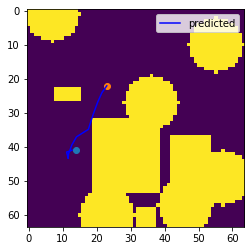

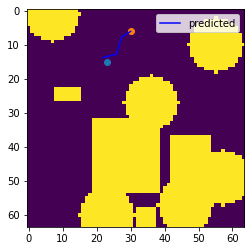

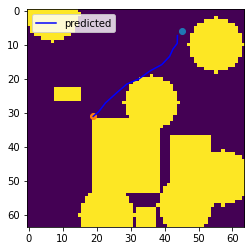

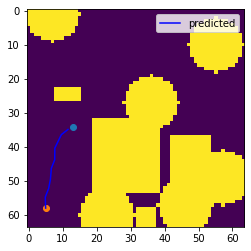

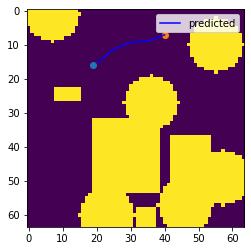

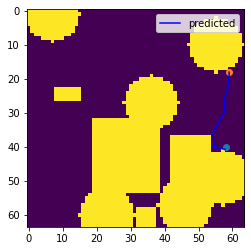

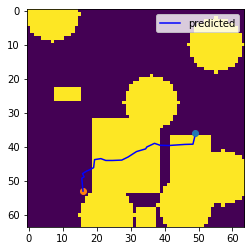

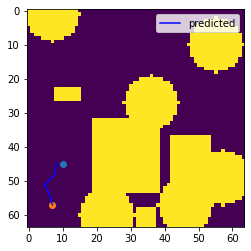

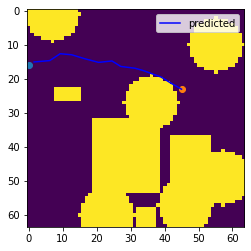

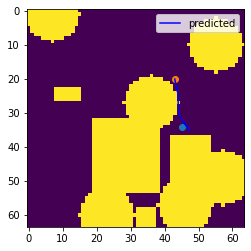

In [21]:
# load map lstm was not trained on:
# flat_map = np.loadtxt(f"./env/{MAP_NAME}/{MAP_NAME}.txt", skiprows=2)                                                   # load in the flat path from file
flat_map = np.loadtxt(f"./env/many_maps_1/{DATASET}/map_2/map_2.txt")
map = torch.tensor(np.asarray(flat_map, dtype=int).reshape(MAP_SHAPE[0], MAP_SHAPE[1])).to(device, dtype=torch.float)     # unflatten the map from the file
map_4d = map.unsqueeze(0).unsqueeze(0)
encoded_map = encoder(map_4d)

# testing to see if it follows new paths:
non_obs_coords = np.transpose(torch.flipud(np.argwhere(map.cpu()==0)))
# print(non_obs_coords)

start_points_list = []
coords_list = []

num_points = 30 # num points to predict for each path
paths_to_gen = 10 # num paths to generate

for x in range(paths_to_gen):
    start_point = random.choice(non_obs_coords).float().to(device)
    goal_point = random.choice(non_obs_coords).float().to(device)

    points = []
    with torch.no_grad():
        pred = start_point
        points.append(pred.cpu().detach().numpy().tolist())
        for point in range(num_points):
            pred = rnn(goal_point, pred, encoded_map).squeeze()
            points.append(pred.cpu().detach().numpy().tolist())
            if check_prox(goal_point.cpu().detach().numpy().tolist(), pred.cpu().detach().numpy().tolist(), 2): # stop predicting if close to goal
                break

    xs = []
    ys = []
    for x,y in points:
        xs.append(x)
        ys.append(y)

    plt.imshow(map.cpu())
    plt.plot(xs, ys, color='b', label = "predicted")
    plt.scatter(goal_point[0].cpu(), goal_point[1].cpu())
    plt.scatter(start_point[0].cpu(), start_point[1].cpu())
    plt.legend()
    plt.show()